# Testing normal forms

Here a normal form model for a planar limit cycle oscillator under the control of a Hopf and a SNIC bifurcations is tested. The model is given by
$$\frac{dx}{dt}= x (\beta-x^2-y^2) - \omega_0 (1 -\lambda y) x,$$
$$\frac{dy}{dt}= y (\beta-x^2-y^2) + \omega_0 (1 -\lambda y) y,$$
where $x$ and $y$ are variables defining the system, $\beta$ and $\lambda$ are parameters controlling the Hopf and SNIC bifurcations, respectively, and $\omega_0$ is the oscillator frequency for $\lambda = 0$.

The model can be rewritten in polar form
$$\frac{dr}{dt}=r (\beta-r^2),$$
$$\frac{d\theta }{dt}=\omega_0 (1 - \lambda r \sin \theta),$$
where $x=r \cos \theta$ and $y = r \sin \theta$.

To simplify, I will defined $\omega_0 = 2\pi$, $\beta_{max}=1$. Units of time will be chosen so as one unit of time is a single oscillation at $\lambda = 0$ ($T=2\pi$).

### 0. Prerequisites

_Loading the libraries_
- Numpy
- Scipy
- Matplotlib

In [ ]:
import numpy as np
from scipy.integrate import odeint
import scipy.signal as sig
import matplotlib.pyplot as plt
from matplotlib import gridspec

_Defining the functions_:

- Hopf_model: The original model, for fixed values of $\beta$ and $\lambda$ 
- Hopf_model_param: A model with a linear increase of $\beta$ (mode = 'beta') or $\lambda$ (mode = 'lambda'), bounded for the range [0, 1]. 
- Hopf_model_param_nolim: A model with a linear increase of $\beta$ (mode = 'beta') or $\lambda$ (mode = 'lambda'), with no bounds. 

In [6]:
def Hopf_model(X,t):
    R = X[0]**2+X[1]**2;
    dxdt = np.array([k*X[0]*(beta-R) - X[1]*omega*(1-lambd*X[1]),\
                     k*X[1]*(beta-R) + X[0]*omega*(1-lambd*X[1])])
    return dxdt

def Hopf_model_param(X,t,omega, k, altpam, paramv,p0,t0, mode):
    R = X[0]**2+X[1]**2;
    
    if mode == 'beta':
        beta = paramv*(t-t0)+p0
        beta = np.maximum(beta,0)
        beta = np.minimum(beta,1)
        lambd = altpam
    
    if mode == 'lambda':
        lambd = paramv*(t-t0)+p0
        lambd = np.maximum(lambd,0)
        lambd = np.minimum(lambd,1)
        beta = altpam
    
    dxdt = np.array([k*X[0]*(beta-R) - X[1]*omega*(1-lambd*X[1]),\
                     k*X[1]*(beta-R) + X[0]*omega*(1-lambd*X[1])])
    return dxdt

def Hopf_model_param_nolim(X,t,omega, k, altpam, paramv,p0,t0, mode):
    R = X[0]**2+X[1]**2;
    
    if mode == 'beta':
        beta = paramv*(t-t0)+p0
        lambd = altpam
    
    if mode == 'lambda':
        lambd = paramv*(t-t0)+p0
        beta = altpam
    
    dxdt = np.array([k*X[0]*(beta-R) - X[1]*omega*(1-lambd*X[1]),\
                     k*X[1]*(beta-R) + X[0]*omega*(1-lambd*X[1])])
    return dxdt

_Defining auxiliary functions_

In [7]:
def AMFM_values(Xs):
    # Computing analytic signal
    anal_sig = Xs[:,0]+1j*Xs[:,1]
    
    # Computing AMFM values
    amp = np.abs(anal_sig)
    phs = np.unwrap(np.angle(anal_sig))
    frq = np.diff(phs)
    
    return anal_sig, amp, phs, frq

def comp_beta_features(amp, betavals, dt, ts, norm):
    amp_diff = np.sqrt(betavals)-amp
    amp_der_diff = -np.diff(amp_diff)/dt
    amp_der = np.diff(amp)/dt
    per_LC = (np.sqrt(betavals)-amp)/(np.sqrt(betavals)+1e-5)
    max_vel = max(amp_der)
    
    if norm == 1:
        amp_diff = amp_diff/max(amp_diff)
        amp_der_diff = amp_der_diff/max(amp_der_diff)
        amp_der = amp_der/max_vel
    
    return amp_diff, amp_der_diff, amp_der, per_LC, max_vel

def comp_lambda_features(phs, lambdvals, dt, ts, norm):
    period_1 = sum((phs<2*np.pi))*dt
    period_2 = sum((phs<np.pi))*dt
    period_4 = sum((phs<np.pi/2))*dt
    frq_avg = np.sqrt(1-lambdvals**2)
    cte_phs = 2*np.pi*(ts-ts[-1])+phs[-1]
    
    if norm == 1:
        period_1 = period_1/2/np.pi
        period_2 = period_2/2/np.pi
        period_4 = period_4/2/np.pi
    
    return period_1, period_2, period_4, frq_avg, cte_phs

def plot_temp_evol(ts, Xs, amp, betavals):
    # Plotting parameters
    fig = plt.figure(figsize=(15, 5)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Temporal evolution
    ax0.plot(ts,Xs)
    ax0.plot(ts,amp,'r:')
    ax0.plot(ts,-amp,'r:')
    ax0.plot(ts,betavals,'k:')
    ax0.plot(ts,np.sqrt(betavals),'g:')
    ax0.plot(ts,-np.sqrt(betavals),'g:')
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Levels')
    
    # Phase space
    ax1.plot(Xs[:,0], Xs[:,1],'r')
    ax1.set_xlabel('x levels')
    ax1.set_ylabel('y levels')
    ax1.grid()
    
    # Other plotting parameters
    plt.tight_layout()
    
def plot_features(ts, Xs, amp, paramvals, dt, paramsel):
    
    # Plotting parameters
    fig = plt.figure(figsize=(15, 10)) 
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    
    # Temporal evolution
    ax0.plot(ts,Xs)
    ax0.plot(ts,paramvals,'k:')
    ax0.plot(ts,amp,'r:')
    ax0.plot(ts,-amp,'r:')
    ax0.grid()
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Levels')
    
    # Phase space
    ax1.plot(Xs[:,0], Xs[:,1],'r')
    ax1.set_xlabel('x levels')
    ax1.set_ylabel('y levels')
    ax1.grid()
    
    # Selection
    if paramsel == 'beta':
        # Normalised
        norm = 1
        (amp_diff, amp_der_diff, amp_der, per_LC, max_vel) = comp_beta_features(amp, paramvals, dt, ts, norm)
        ax0.plot(ts,np.sqrt(paramvals),'g:')
        ax0.plot(ts,-np.sqrt(paramvals),'g:')
        
        # Temporal evolution
        ax2.plot(ts,amp_diff)
        ax2.plot(ts[1:],(amp_der_diff)*(per_LC[1:]>1e-2))
        ax2.plot(ts,per_LC)
        #ax2.plot(ts[1:],amp_der)
        ax2.grid()
        ax2.set_ylim(bottom = 0)
        if norm == 1:
            ax2.set_ylim(top = 1.1)
            ax2.set_ylabel('Features')
        
    if paramsel == 'lambda':
        # Normalised
        norm = 0
        phs_adj = phs-phs[0]
        (period_1, period_2, period_4, frq_avg, cte_phs) = comp_lambda_features(phs_adj, paramvals, dt, ts, norm)
        ax0.plot(ts,frq_avg,'g:')
        ax0.plot([period_1, period_1],[-1,1],'c:')
        ax0.plot([period_4, period_4],[-1,1],'c:')
        
        # Temporal evolution
        ax2.plot(ts,phs,'k')
        ax2.plot(ts,cte_phs+phs[0],'b:')
        ax2.grid()
        ax2.set_ylim(bottom = 0)     
        ax2.set_ylabel('Instantaneous phase')
        
    ax2.set_xlabel('Time')
    
    # Other plotting parameters
    plt.tight_layout()
    
def sim_summary(r_init, m0, muv, t0):
    print("Initial conditions = "+np.str(r_init))
    print("Initial parameter value = "+np.str(m0))
    TMU = abs(1/muv);
    TMU = np.double(TMU)
    print("Time for the parameter to reach the maximum level = "+np.str(TMU.round(2))+" (periods)")
    print("Bifurcation time = "+np.str(t0))

def plot_heatmap_rep(map2plot, x_vec, y_vec, feature_sel, param_sel, scal, plot_extreme):
    if scal == 'log':
        x_vec_log = np.log10(x_vec)   
    if scal == 'lin':
        x_vec_log = x_vec
        
    ax_sel = np.round((len(y_vec)+1)/2)
    ax_sel = np.int(ax_sel)
        
    fig, axs = plt.subplots(2,2,figsize=(15,6))

    fig = plt.subplot(1,2,1)
    sns.heatmap(map2plot, xticklabels = x_vec_log.round(2), yticklabels = y_vec.round(2), ax=fig)
    plt.xlabel('Initial position')
    if plot_extreme == 4: 
        plt.xlabel('k')
    plt.ylabel('Rate of change of '+ param_sel)
    fig.invert_yaxis()
    plt.title(feature_sel)

    axs[0,1].plot(x_vec,map2plot[0,:])
    if plot_extreme == 1: 
        axs[0,1].plot(x_vec,map2plot[-1,:])
    if plot_extreme == 2: 
        axs[0,1].plot(x_vec,map2plot[-1,:])
    axs[0,1].set_xlabel('Initial position')
    axs[0,1].set_ylabel(feature_sel)

    axs[1,1].plot(y_vec,map2plot[:,0])
    if plot_extreme == 1: 
        axs[1,1].plot(y_vec,map2plot[:,-1])
    if plot_extreme == 2: 
        axs[1,1].plot(y_vec,map2plot[:,-1])
        axs[1,1].plot(y_vec,map2plot[:,ax_sel])
    if plot_extreme == 4: 
        axs[0,1].plot(x_vec,map2plot[-1,:])
        axs[1,1].plot(y_vec,map2plot[:,-1])
        axs[0,1].set_xlabel('k')
    axs[1,1].set_xlabel('Rate of change of '+ param_sel)
    axs[1,1].set_ylabel(feature_sel)

    return axs

### 1. Simulations for fixed parameters

_How does the model behaves for a fixed parameters values?_

In [8]:
# Model parameters
mode = 'beta'
omega = 2*np.pi
lambd = 0
betav  = 0
t0 = 0
b0 = 1
k = omega

# Integrator parameters
r_init = 1e-5
dt = 1e-3
TMAX = 10

X0 = [0, r_init]
ts = np.arange(0,TMAX,dt)

# Integration
Xs = odeint(Hopf_model_param, X0, ts, args = (omega, k, lambd, betav, b0, t0, mode))

# Beta evolution
betavals = betav*(ts-t0)+b0
betavals = np.maximum(betavals,0)
betavals = np.minimum(betavals,1)

# Extract AMFM Parameters
(anal_sig, amp, phs, frq) = AMFM_values(Xs)

Initial conditions = 1e-05
Initial parameter value = 1
Time for the parameter to reach the maximum level = 1.0 (periods)
Bifurcation time = 0


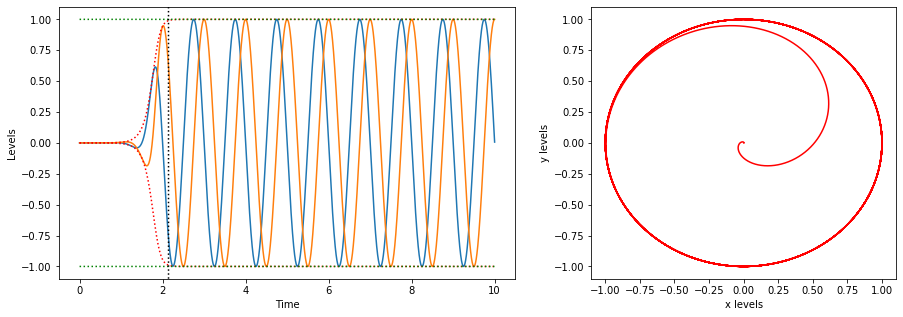

In [9]:
# Presenting the summary
sim_summary(r_init, b0, 1, t0)

# Plotting features
# Plotting parameters
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1,2 , width_ratios=[3, 2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# Temporal evolution
ax0.plot(ts,Xs)
#ax0.plot(ts,betavals,'k:')
ax0.plot(ts,amp,'r:')
ax0.plot(ts,-amp,'r:')
#ax0.plot(ts,betavals,'c')
ax0.plot(ts,np.sqrt(betavals),'g:')
ax0.plot(ts,-np.sqrt(betavals),'g:')

# Temporal evolution
(amp_diff, amp_der_diff, amp_der, per_LC, max_vel) = comp_beta_features(amp, betavals, dt, ts, 1)

#ax0.plot(ts[1:],4*((amp_der_diff>1e-3)*(per_LC[1:]>1e-2))-2,'k:')
ax0.plot(ts,4*(per_LC>1e-2)-2,'k:')
ax0.set_ylim([-1.1*np.sqrt(betavals[-1]), 1.1*np.sqrt(betavals[-1])])

#ax0.grid()
ax0.set_xlabel('Time')
ax0.set_ylabel('Levels')

# Phase space
ax1.plot(Xs[:,0], Xs[:,1],'r')
#ax1.grid()
ax1.set_xlabel('x levels')
ax1.set_ylabel('y levels')

# Saving
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('Constant_beta.pdf')

### 2. Simulations for changing parameters

_How does the model behaves when $\beta$ changes?_

In [27]:
# Model parameters
mode = 'beta'
omega = 2*np.pi
lambd = 0
betav  = 1/5
t0 = 0
b0 = 0
k = omega

# Integrator parameters
r_init = 1e-5
dt = 1e-3
TMAX = 10

X0 = [0, r_init]
ts = np.arange(0,TMAX,dt)

# Integration
Xs = odeint(Hopf_model_param, X0, ts, args = (omega, k, lambd, betav, b0, t0, mode))

# Beta evolution
betavals = betav*(ts-t0)+b0
betavals = np.maximum(betavals,0)
betavals = np.minimum(betavals,1)

# Extract AMFM Parameters
(anal_sig, amp, phs, frq) = AMFM_values(Xs)

Initial conditions = 1e-05
Initial parameter value = 0
Time for the parameter to reach the maximum level = 5.0 (periods)
Bifurcation time = 0


Text(0, 0.5, 'y levels')

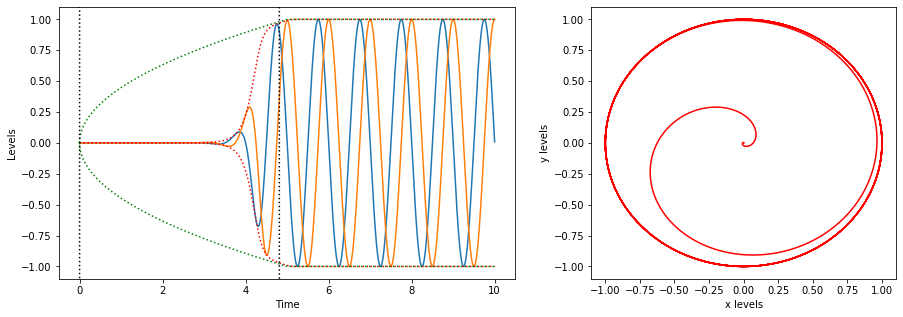

In [30]:
# Presenting the summary
sim_summary(r_init, b0, betav, t0)

# Plotting features
# Plotting parameters
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1,2 , width_ratios=[3, 2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# Temporal evolution
ax0.plot(ts,Xs)
ax0.plot(ts,amp,'r:')
ax0.plot(ts,-amp,'r:')
ax0.plot(ts,np.sqrt(betavals),'g:')
ax0.plot(ts,-np.sqrt(betavals),'g:')

# Temporal evolution
(amp_diff, amp_der_diff, amp_der, per_LC, max_vel) = comp_beta_features(amp, betavals, dt, ts, 1)

ax0.plot(ts,4*(per_LC>1e-2)-2,'k:')
ax0.set_ylim([-1.1*np.sqrt(betavals[-1]), 1.1*np.sqrt(betavals[-1])])

#ax0.grid()
ax0.set_xlabel('Time')
ax0.set_ylabel('Levels')

# Phase space
ax1.plot(Xs[:,0], Xs[:,1],'r')
#ax1.grid()
ax1.set_xlabel('x levels')
ax1.set_ylabel('y levels')


_How does the model behaves when $\lambda$ changes?_

In [15]:
# Model parameters
mode = 'lambda'
omega = 2*np.pi
beta = 1
lambdv  = -1/5
t0 = 0
l0 = 1
k = omega

# Integrator parameters
r_init = 1
dt = 1e-3
TMAX = 10

X0 = [0, np.sqrt(beta)]
ts = np.arange(0,TMAX,dt)

# Integration
Xs = odeint(Hopf_model_param, X0, ts, args = (omega, k, beta, lambdv, l0, t0, mode))

# Beta evolution
lambdvals = lambdv*(ts-t0)+l0
lambdvals = np.maximum(lambdvals,0)
lambdvals = np.minimum(lambdvals,1)

# Extract AMFM Parameters
(anal_sig, amp, phs, frq) = AMFM_values(Xs)

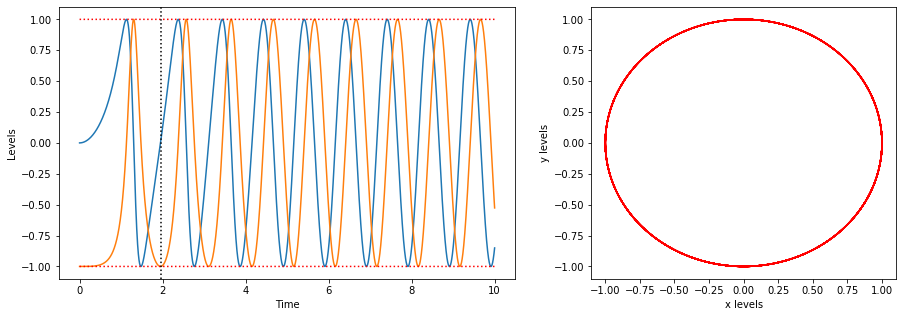

In [16]:
# Presenting the summary
#sim_summary(r_init, l0, lambdv, t0)

# Plotting features
# Plotting parameters
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1,2 , width_ratios=[3, 2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# Temporal evolution
ax0.plot(ts,-Xs)
#ax0.plot(ts,betavals,'k:')
ax0.plot(ts,amp,'r:')
ax0.plot(ts,-amp,'r:')

# Temporal evolution
phs_adj = phs-phs[0]
(period_1, period_2, period_4, frq_avg, cte_phs) = comp_lambda_features(phs_adj, lambdvals, dt, ts, 0)

ax0.plot([period_1, period_1],[-1.1,1.1],'k:')
ax0.set_ylim([-1.1, 1.1])

#ax0.grid()
ax0.set_xlabel('Time')
ax0.set_ylabel('Levels')

# Phase space
ax1.plot(Xs[:,0], Xs[:,1],'r')
#ax1.grid()
ax1.set_xlabel('x levels')
ax1.set_ylabel('y levels')

# Saving
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('Constant_SNIC.pdf')

### 3. The dynamics under changes in $\beta$

_Integrating over different values of $\beta$ rate of change_

In [18]:
# Iteration features
mode = 'beta'
norm = 1
n_elements = 151

# Model parameters
omega = 2*np.pi
lambd = 0
t0 = 0
b0 = 0
k = omega

# Integrator parameters
dt = 1e-3
TMAX = 20
r_init = 1e-5;
ts = np.arange(0,TMAX,dt)

# Testing parameters
initvec = np.linspace(r_init,r_init,1) #r_init
betavec = np.linspace(2/TMAX,TMAX,n_elements)

# Storing matrices
transient = np.zeros([len(betavec),len(initvec)])
delay = np.zeros([len(betavec),len(initvec)])
envel = np.zeros([len(betavec),len(initvec)])
top_vel = np.zeros([len(betavec),len(initvec)])
final_amplitude = np.zeros([len(betavec),len(initvec)])
compr = np.zeros([len(betavec),len(initvec)])
envel_alt = np.zeros([len(betavec),len(initvec)])

for bets in np.arange(0,len(betavec)):
    betav = betavec[bets]
    for inits in np.arange(0,len(initvec)):
        r_init = initvec[inits]
        
        # Integrator parameters
        X0 = [0, 0 + r_init]
        
        # Integrator
        Xs = odeint(Hopf_model_param_nolim, X0, ts, args = (omega, k, lambd, betav, b0, t0, mode))

        # Betavalues
        betavals = betav*(ts-t0)+b0
        #betavals = np.maximum(betavals,0)
        #betavals = np.minimum(betavals,1)

        # Extract AMFM Parameters
        (anal_sig, amp, phs, frq) = AMFM_values(Xs)
        
        # Computation of features
        (amp_diff, amp_der_diff, amp_der, per_LC, max_vel) = comp_beta_features(amp, betavals, dt, ts, norm)
        
        # Computing matrices
        LC_TH = per_LC[1:]>1e-2
        
        transient[bets, inits] = sum(per_LC>1e-2)/len(ts)*TMAX
        delay[bets,inits] = (sum(((amp-r_init)>((1-r_init)*5e-2)))-sum(betavals>0))/len(ts)*TMAX
        
        envel[bets,inits] = sum((amp_der_diff>1e-3)*LC_TH)/len(ts)*TMAX
        #envel[bets,inits] = sum(amp_der_diff>1.5e-2)/len(ts)*TMAX
        #envel[bets,inits] = sum(amp_der>5e-2)/len(ts)*TMAX
        envel_alt[bets,inits] = sum(amp_der_diff>max(amp_der_diff)/50)/len(ts)*TMAX 
        final_amplitude[bets, inits] = amp[-1]
        top_vel[bets,inits] = max_vel
        
        compr[bets,inits] = sum((betavals>0)*((np.sqrt(betavals)-amp)**2>1e-3))/len(ts)*TMAX       
        

_Plotting the results_

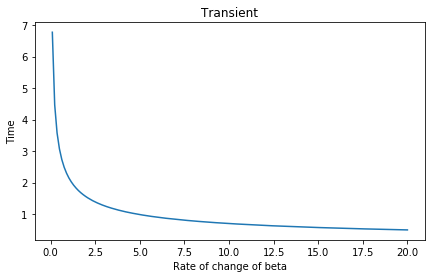

In [20]:
betarate = betavec;

fig, axs = plt.subplots(figsize=(7,4))

axs.plot(betarate,transient)
axs.set_xlabel('Rate of change of beta')
axs.set_ylabel('Time')
axs.set_title('Transient')

# Saving
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('Beta_reach_Hopf.pdf')

_Comparing different cases_

The value for db/dt is 0.1 and the value for r_0 is 1e-05
The value for db/dt is 5.0 and the value for r_0 is 1e-05


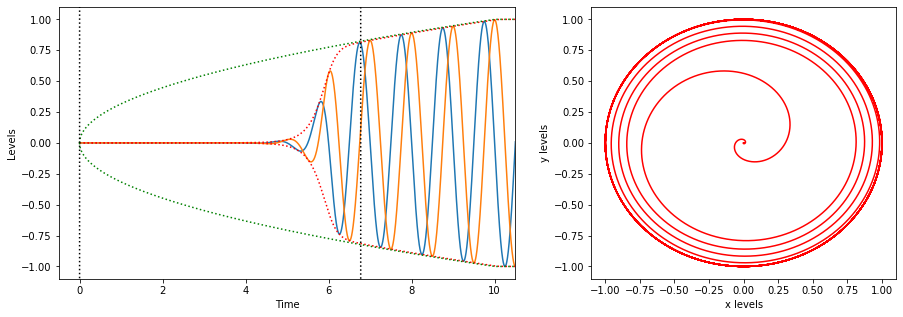

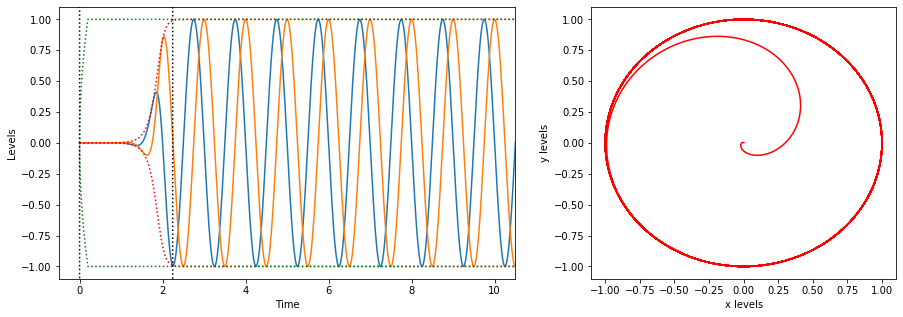

In [21]:
# Extreme cases
# Testing parameters
r_init = 1e-5
betavec = np.linspace(2/TMAX,5,n_elements)

x_ext = [r_init,r_init]
y_ext = [betavec[0],betavec[-1]]

# Model parameters
mode = 'beta'
omega = 2*np.pi
lambd = 0
t0 = 0
b0 = 0
k = omega

# Integrator parameters
dt = 1e-3
#TMAX = 30
ts = np.arange(0,TMAX,dt)

for vals in np.arange(0,len(x_ext)):
    betav = y_ext[vals]
    r_init = x_ext[vals]

    X0 = [0, r_init]

    # Integration
    Xs = odeint(Hopf_model_param, X0, ts, args = (omega, k, lambd, betav, b0, t0, mode))

    # Beta evolution
    betavals = betav*(ts-t0)+b0
    betavals = np.maximum(betavals,0)
    betavals = np.minimum(betavals,1)

    # Extract AMFM Parameters
    (anal_sig, amp, phs, frq) = AMFM_values(Xs)
    
    # Plotting features
    print('The value for db/dt is '+np.str(betav.round(2))+' and the value for r_0 is '+np.str(r_init))
    
    # Plotting features
    # Plotting parameters
    fig = plt.figure(figsize=(15, 5)) 
    gs = gridspec.GridSpec(1,2 , width_ratios=[3, 2]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Temporal evolution
    ax0.plot(ts,Xs)
    #ax0.plot(ts,betavals,'k:')
    ax0.plot(ts,amp,'r:')
    ax0.plot(ts,-amp,'r:')
    ax0.plot(ts,np.sqrt(betavals),'g:')
    ax0.plot(ts,-np.sqrt(betavals),'g:')

    # Temporal evolution
    (amp_diff, amp_der_diff, amp_der, per_LC, max_vel) = comp_beta_features(amp, betavals, dt, ts, 1)

    ax0.plot(ts,4*(per_LC>1e-2)-2,'k:')
    ax0.set_ylim([-1.1*np.sqrt(betavals[-1]), 1.1*np.sqrt(betavals[-1])])

    #ax0.grid()
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Levels')
    ax0.set_xlim([-0.5,10.5])

    # Phase space
    ax1.plot(Xs[:,0], Xs[:,1],'r')
    #ax1.grid()
    ax1.set_xlabel('x levels')
    ax1.set_ylabel('y levels')

    # Saving
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    name_sel = 'Extreme_Hopf_shrt_' + np.str(vals) + '.pdf'
    plt.savefig(name_sel)

### 4. The dynamics under changes in $\lambda$

_Integrating over different values of $\lambda$ rate of change_

In [31]:
# Iteration features
mode = 'lambda'
norm = 0
n_elements = 151

# Model parameters
omega = 2*np.pi
beta = 1
t0 = 0
l0 = 1
k = omega

# Integrator parameters
dt = 1e-3
TMAX = 20
ts = np.arange(0,TMAX,dt)

# Testing parameters
initvec = np.linspace(-np.pi/9,np.pi/9,3)
lambdvec = np.linspace(2/TMAX,1/1,n_elements)

# Storing matrices
PER_1 = np.zeros([len(lambdvec),len(initvec)])
PER_2 = np.zeros([len(lambdvec),len(initvec)])
PER_4 = np.zeros([len(lambdvec),len(initvec)])
Delay = np.zeros([len(lambdvec),len(initvec)])

PER_1_adj = np.zeros([len(lambdvec),len(initvec)])
PER_2_adj = np.zeros([len(lambdvec),len(initvec)])
PER_4_adj = np.zeros([len(lambdvec),len(initvec)])
Delay_adj = np.zeros([len(lambdvec),len(initvec)])

top_vel = np.zeros([len(lambdvec),len(initvec)])
final_amplitude = np.zeros([len(lambdvec),len(initvec)])
compr = np.zeros([len(lambdvec),len(initvec)])
envel_alt = np.zeros([len(lambdvec),len(initvec)])

for lambds in np.arange(0,len(lambdvec)):
    lambdv = -lambdvec[lambds]
    for inits in np.arange(0,len(initvec)):
        r_init = np.pi/2 + initvec[inits]
        
        # Integrator parameters
        X0 = [np.cos(r_init), np.sin(r_init)]
        
        # Integrator
        Xs = odeint(Hopf_model_param, X0, ts, args = (omega, k, beta, lambdv, l0, t0, mode))

        # Betavalues
        lambdvals = lambdv*(ts-t0)+l0
        lambdvals = np.maximum(lambdvals,0)
        lambdvals = np.minimum(lambdvals,1)

        # Extract AMFM Parameters
        (anal_sig, amp, phs, frq) = AMFM_values(Xs)
        phs_adj = phs - phs[0]
        
        # Computation of features
        (period_1, period_2, period_4, frq_avg, cte_phs) = comp_lambda_features(phs, lambdvals, dt, ts, norm)
        PER_1[lambds,inits] = period_1
        PER_2[lambds,inits] = period_2
        PER_4[lambds, inits] = period_4
        Delay[lambds, inits] = period_4/period_1
        
        # Computation of features
        (period_1, period_2, period_4, frq_avg, cte_phs) = comp_lambda_features(phs_adj, lambdvals, dt, ts, norm)
        PER_1_adj[lambds,inits] = period_1
        PER_2_adj[lambds,inits] = period_2
        PER_4_adj[lambds, inits] = period_4
        Delay_adj[lambds, inits] = period_4/period_1

_Plotting the results_

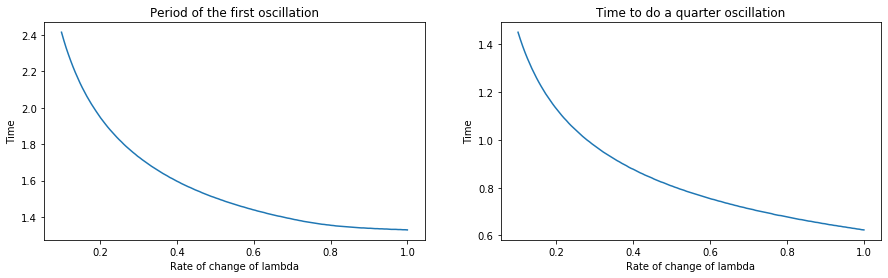

In [32]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(lambdvec,PER_1_adj[:,1])
axs[0].set_xlabel('Rate of change of lambda')
axs[0].set_ylabel('Time')
axs[0].set_title('Period of the first oscillation')

axs[1].plot(lambdvec,PER_4_adj[:,1])
axs[1].set_xlabel('Rate of change of lambda')
axs[1].set_ylabel('Time')
axs[1].set_title('Time to do a quarter oscillation')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('SNIC_Parameter.pdf')

_Comparing different cases_

The value for db/dt is -0.1 and the value for r_0 is 1.5707963267948966
The value for db/dt is -1.0 and the value for r_0 is 1.5707963267948966


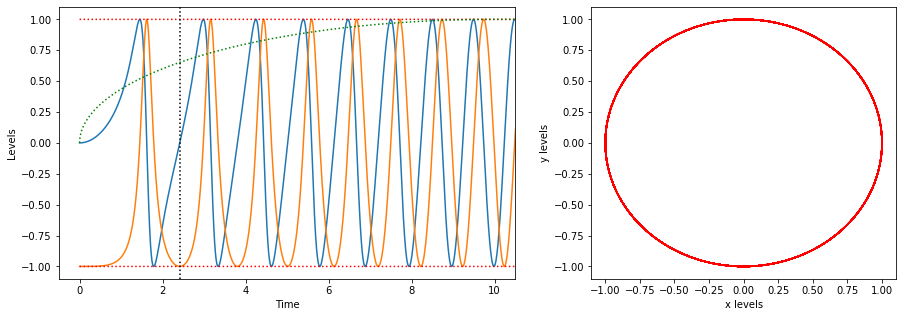

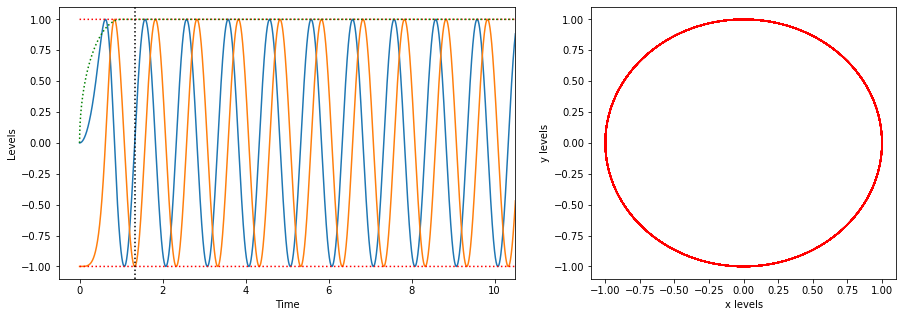

In [34]:
# Extreme cases
# Testing parameters
initvec = np.linspace(-np.pi/9,np.pi/9,3)
lambdvec = np.linspace(2/TMAX,1/1,n_elements)

x_ext = [initvec[1],initvec[1]]
y_ext = [lambdvec[0],lambdvec[-1]]

# Model parameters
mode = 'lambda'
omega = 2*np.pi
beta = 1
t0 = 0
l0 = 1
k = omega

# Integrator parameters
dt = 1e-3
#TMAX = 30
ts = np.arange(0,TMAX,dt)

for vals in np.arange(0,len(x_ext)):
    lambdv = -y_ext[vals]
    r_init = np.pi/2 + x_ext[vals]

    X0 = [np.cos(r_init), np.sin(r_init)]

    # Integration
    Xs = odeint(Hopf_model_param, X0, ts, args = (omega, k, beta, lambdv, l0, t0, mode))

    # Beta evolution
    lambdvals = lambdv*(ts-t0)+l0
    lambdvals = np.maximum(lambdvals,0)
    lambdvals = np.minimum(lambdvals,1)

    # Extract AMFM Parameters
    (anal_sig, amp, phs, frq) = AMFM_values(Xs)
    
    # Plotting features
    print('The value for db/dt is '+np.str(lambdv.round(2))+' and the value for r_0 is '+np.str(r_init))
    # Plotting features
    # Plotting parameters
    fig = plt.figure(figsize=(15, 5)) 
    gs = gridspec.GridSpec(1,2 , width_ratios=[3, 2]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Temporal evolution
    ax0.plot(ts,-Xs)
    #ax0.plot(ts,betavals,'k:')
    ax0.plot(ts,amp,'r:')
    ax0.plot(ts,-amp,'r:')

    # Temporal evolution
    phs_adj = phs-phs[0]
    (period_1, period_2, period_4, frq_avg, cte_phs) = comp_lambda_features(phs_adj, lambdvals, dt, ts, 0)

    ax0.plot(ts,frq_avg,'g:')
    ax0.plot([period_1, period_1],[-1.1,1.1],'k:')
    #ax0.plot([period_4, period_4],[-1.1,1.1],'k:')
    ax0.set_ylim([-1.1, 1.1])

    #ax0.grid()
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Levels')
    ax0.set_xlim([-0.5,10.5])

    # Phase space
    ax1.plot(Xs[:,0], Xs[:,1],'r')
    #ax1.grid()
    ax1.set_xlabel('x levels')
    ax1.set_ylabel('y levels')
    
    # Saving
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    name_sel = 'Extreme_SNIC_' + np.str(vals) + '.pdf'
    plt.savefig(name_sel)